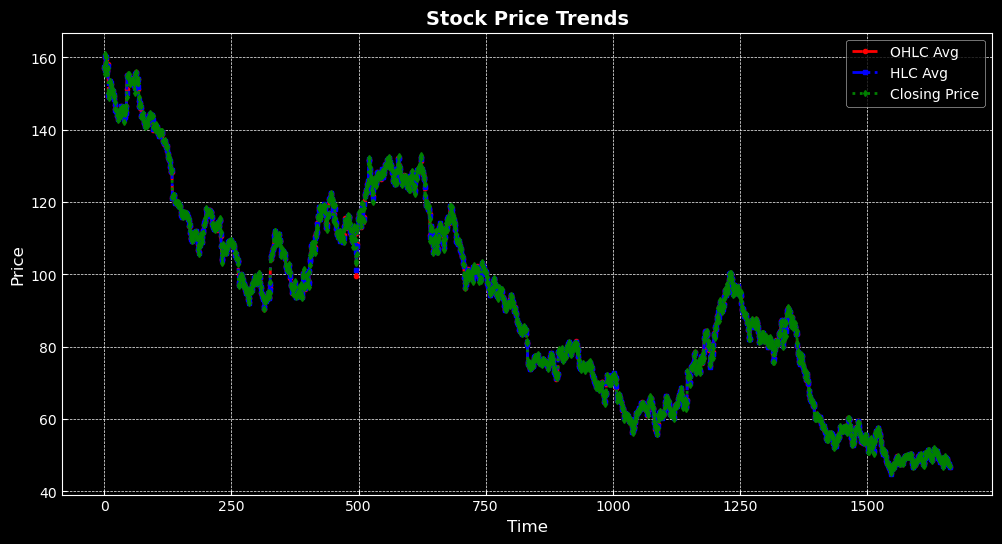

C:\Users\gaura\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 4s 995us/step - loss: 0.0213
Epoch 2/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - loss: 2.5554e-04
Epoch 3/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - loss: 1.9559e-04
Epoch 4/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - loss: 2.0032e-04
Epoch 5/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 2.1970e-04
Epoch 6/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - loss: 1.8491e-04
Epoch 7/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - loss: 2.1201e-04
Epoch 8/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - loss: 1.6424e-04
Epoch 9/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - loss: 1.9492e-04
Epoch 10/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - loss: 2.5610e-04
Epoch 11/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - loss: 1.7600e-04
Epoch 12/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - loss: 2.3525e-04
Epoch 13/50
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - loss: 1.8340e-04
Epoch 14/50
1330/1330 ━━━

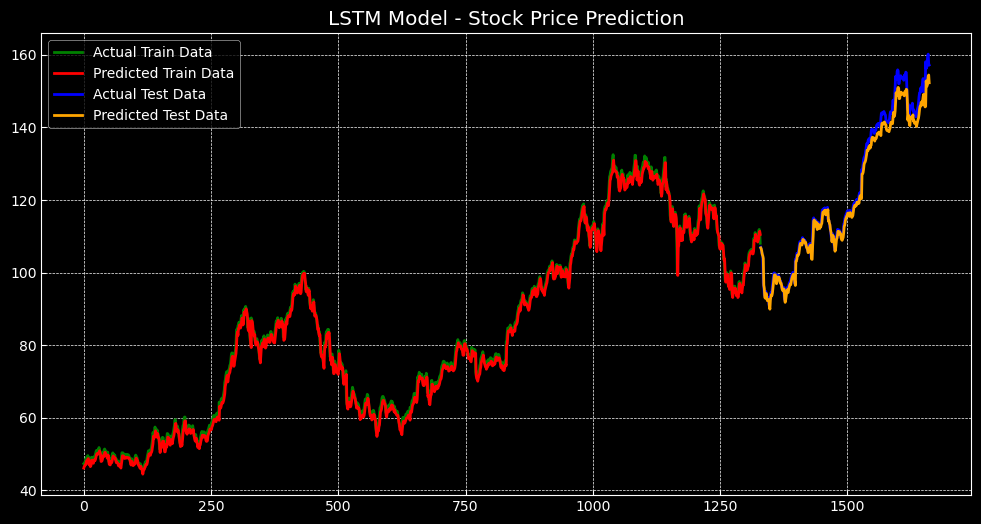

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Last Day Value: 152.29297
Next Day Predicted Value: 148.12978


In [15]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

# FOR REPRODUCIBILITY
np.random.seed(7)

# IMPORTING DATASET
file_path = r'C:\Users\SWAPNIL PATIL\Downloads\apple_share_price.csv'  # Use raw string (r'')
dataset = pd.read_csv(file_path)

# REVERSE THE DATASET (IF NEEDED)
dataset = dataset.iloc[::-1]

# TAKING IMPORTANT FEATURES
OHLC_avg = dataset[['Open', 'High', 'Low', 'Close']].mean(axis=1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis=1)
close_val = dataset[['Close']]

# PLOTTING INDICATORS
plt.figure(figsize=(12, 6))
plt.plot(OHLC_avg, 'r--o', label='OHLC Avg', markersize=3)
plt.plot(HLC_avg, 'b-.s', label='HLC Avg', markersize=3)
plt.plot(close_val, 'g:d', label='Closing Price', markersize=3)
plt.legend(loc='upper right')
plt.title("Stock Price Trends", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.show()

# NORMALIZING DATA
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_scaled = scaler.fit_transform(OHLC_avg.values.reshape(-1, 1))

# SPLITTING DATA INTO TRAIN & TEST
train_size = int(len(OHLC_scaled) * 0.80)
train_OHLC, test_OHLC = OHLC_scaled[:train_size], OHLC_scaled[train_size:]

# FUNCTION TO CREATE TIME-SERIES DATASET
def create_new_dataset(data, step_size=1):
    X, Y = [], []
    for i in range(len(data) - step_size):
        X.append(data[i:(i + step_size), 0])
        Y.append(data[i + step_size, 0])
    return np.array(X), np.array(Y)

# APPLY FUNCTION TO TRAIN & TEST DATA
step_size = 1
trainX, trainY = create_new_dataset(train_OHLC, step_size)
testX, testY = create_new_dataset(test_OHLC, step_size)

# RESHAPING DATA FOR LSTM INPUT (samples, time steps, features)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# BUILDING THE LSTM MODEL
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, step_size)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')

# TRAINING THE MODEL
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

# MAKING PREDICTIONS
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE: %.2f' % trainScore)

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test RMSE: %.2f' % testScore)

# INVERSE TRANSFORM PREDICTIONS TO ORIGINAL SCALE
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# PLOTTING ACTUAL VS PREDICTED
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(trainY)), trainY, 'g', label="Actual Train Data")
plt.plot(np.arange(len(trainPredict)), trainPredict, 'r', label="Predicted Train Data")
plt.plot(np.arange(len(trainY), len(trainY) + len(testY)), testY, 'b', label="Actual Test Data")
plt.plot(np.arange(len(trainPredict), len(trainPredict) + len(testPredict)), testPredict, 'orange', label="Predicted Test Data")
plt.legend()
plt.title("LSTM Model - Stock Price Prediction")
plt.show()

# PREDICT FUTURE VALUE
last_val = testPredict[-1]
last_val_scaled = scaler.transform(np.array(last_val).reshape(-1, 1))  # Scale last value
next_val = model.predict(np.reshape(last_val_scaled, (1, 1, 1)))  # Predict next step
next_val = scaler.inverse_transform(next_val)  # Inverse transform prediction

# DISPLAY FUTURE PREDICTION
print("Last Day Value:", last_val[0])
print("Next Day Predicted Value:", next_val[0][0])

In [1]:
# !pip install --upgrade yfinance

## Stocks Price Prediction

In [20]:
# IMPORTING LIBRARIES
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

# FOR REPRODUCIBILITY
np.random.seed(7)

[*********************100%***********************]  1 of 1 completed


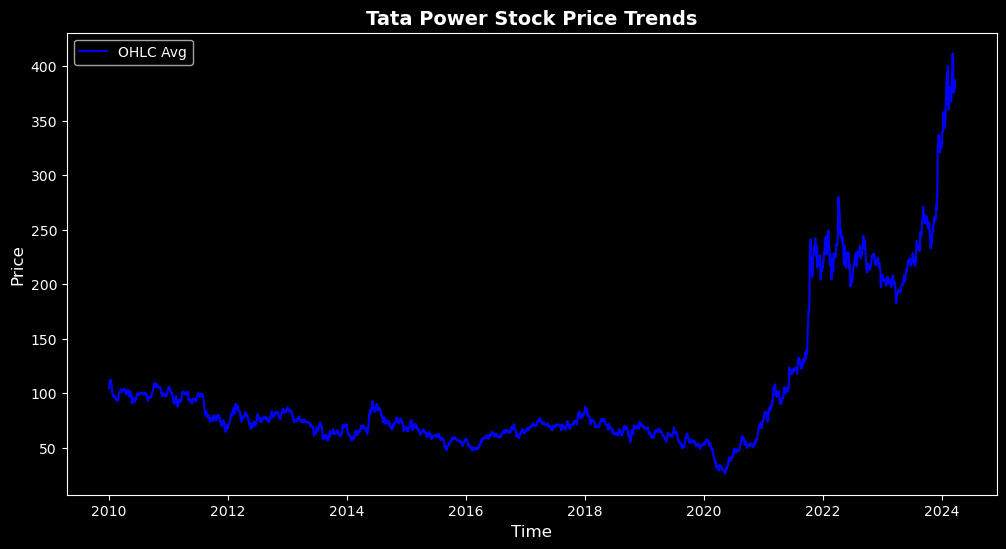

In [21]:
# FETCH TATA POWER STOCK DATA
ticker = "TATAPOWER.NS"  # Tata Power stock symbol on Yahoo Finance
data = yf.download(ticker, start="2010-01-01", end="2024-03-22")  # Fetch data up to 22nd March 2024

# TAKING IMPORTANT FEATURES
OHLC_avg = data[['Open', 'High', 'Low', 'Close']].mean(axis=1)

plt.style.use('dark_background')  # Try 'ggplot', 'bmh', or 'dark_background'

# PLOTTING THE DATA
plt.figure(figsize=(12, 6))
plt.plot(OHLC_avg, 'b', label='OHLC Avg')
plt.title("Tata Power Stock Price Trends", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.show()

In [22]:
# NORMALIZING DATA
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_scaled = scaler.fit_transform(OHLC_avg.values.reshape(-1, 1))

# SPLITTING DATA INTO TRAIN AND VALIDATION
train_size = int(len(OHLC_scaled) * 0.80)  # 80% for training
train_OHLC, val_OHLC = OHLC_scaled[:train_size], OHLC_scaled[train_size:]

# FUNCTION TO CREATE TIME-SERIES DATASET
def create_new_dataset(data, step_size=1):
    X, Y = [], []
    for i in range(len(data) - step_size):
        X.append(data[i:(i + step_size), 0])
        Y.append(data[i + step_size, 0])
    return np.array(X), np.array(Y)

# APPLY FUNCTION TO TRAIN AND VALIDATION DATA
step_size = 1
trainX, trainY = create_new_dataset(train_OHLC, step_size)
valX, valY = create_new_dataset(val_OHLC, step_size)

# RESHAPING DATA FOR LSTM INPUT (samples, time steps, features)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

In [23]:
# BUILDING THE LSTM MODEL
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, step_size)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\SWAPNIL PATIL\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# TRAINING THE MODEL
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=1)

# MAKING PREDICTIONS
trainPredict = model.predict(trainX, verbose=0)
valPredict = model.predict(valX, verbose=0)

# INVERSE TRANSFORM PREDICTIONS TO ORIGINAL SCALE
trainPredict = scaler.inverse_transform(trainPredict)
valPredict = scaler.inverse_transform(valPredict)
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
valY = scaler.inverse_transform(valY.reshape(-1, 1))

Epoch 1/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 8.6834e-04
Epoch 2/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.7624e-05
Epoch 3/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.9903e-05
Epoch 4/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.7250e-05
Epoch 5/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.5463e-05
Epoch 6/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.7510e-05
Epoch 7/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.7503e-05
Epoch 8/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.7466e-05
Epoch 9/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.6698e-05
Epoch 10/10
2807/2807 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.8133e-05


Train RMSE: 1.46
Validation RMSE: 21.81


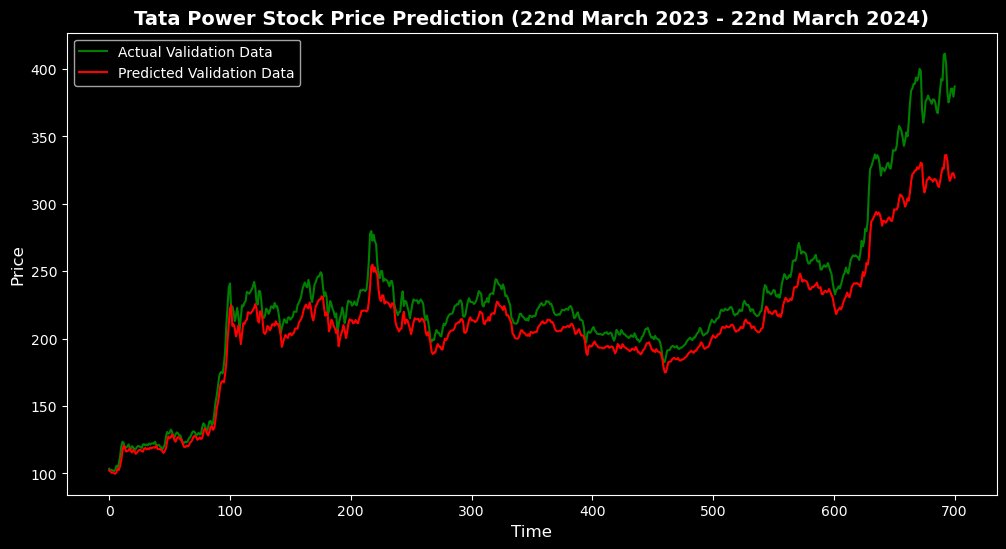

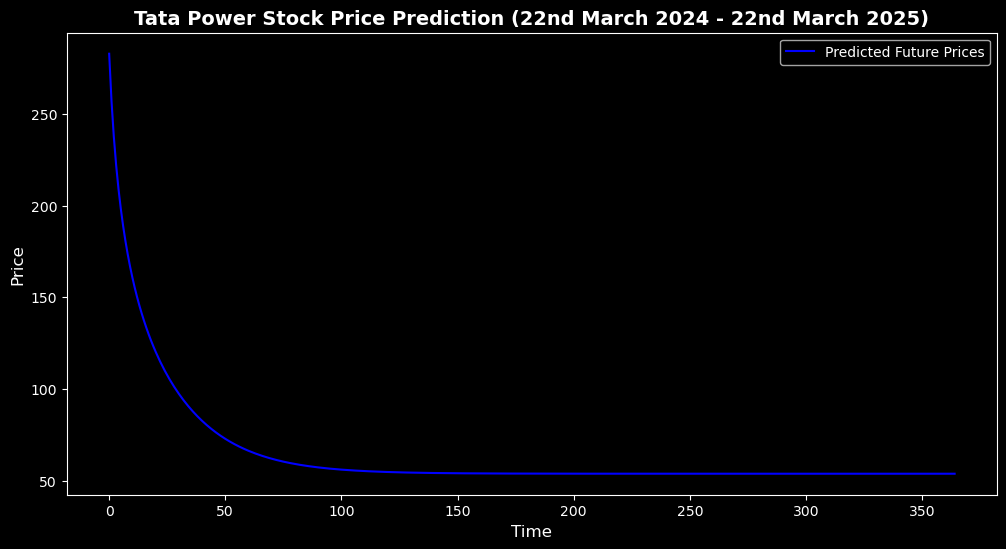

In [25]:
# CALCULATING RMSE
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train RMSE: %.2f' % trainScore)
valScore = math.sqrt(mean_squared_error(valY, valPredict))
print('Validation RMSE: %.2f' % valScore)

# PLOTTING ACTUAL VS PREDICTED FOR VALIDATION PERIOD
plt.figure(figsize=(12, 6))
plt.plot(valY, 'g', label="Actual Validation Data")
plt.plot(valPredict, 'r', label="Predicted Validation Data")
plt.legend()
plt.title("Tata Power Stock Price Prediction (22nd March 2023 - 22nd March 2024)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.show()

# PREDICTING FOR THE NEXT YEAR (22nd March 2024 - 22nd March 2025)
future_predictions = []
last_val = valPredict[-1]
last_val_scaled = scaler.transform(np.array(last_val).reshape(-1, 1))

for _ in range(365):  # Predict for 365 days
    next_val = model.predict(np.reshape(last_val_scaled, (1, 1, 1)), verbose=0)
    future_predictions.append(next_val[0][0])
    last_val_scaled = next_val  # Use the predicted value as the next input

# INVERSE TRANSFORM FUTURE PREDICTIONS
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# PLOTTING FUTURE PREDICTIONS
plt.figure(figsize=(12, 6))
plt.plot(future_predictions, 'b', label="Predicted Future Prices")
plt.legend()
plt.title("Tata Power Stock Price Prediction (22nd March 2024 - 22nd March 2025)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.show()